### Correlations first

In [10]:
from pandas import read_csv
import numpy as np
from pylab import plt
from copy import deepcopy
import warnings
warnings.simplefilter("ignore")

In [3]:
iclr = read_csv("../feature_extraction/iclr.csv")
neurips = read_csv("../feature_extraction/neurips.csv")

iclr.head()

,paper_id,num_equations,mean_num_new_symbols_introduced,num_overall_unique_symbols,mean_num_unique_symbols,std_of_unique_symbols,max_representational_complexity,recommendation_avg,status
0,sKDtBKYOdIP,1057.0,0.070956,75.0,0.988647,2.838764,26.0,5.75,Reject
1,eXkhH12DTD9,160.0,0.318750,51.0,1.681250,3.363459,17.0,5.75,Poster
2,9Zx6tTcX0SE,224.0,0.294643,66.0,3.160714,3.102302,27.0,5.00,Reject
3,qhu9uX4QlP8,518.0,0.154440,80.0,2.415058,3.656891,24.0,5.25,Reject
4,zVrw4OH1Lch,531.0,0.193974,103.0,3.758945,4.007339,25.0,6.00,Poster


In [36]:
iclr_status = []
iclr_indices = []
for i, item in enumerate(iclr["status"]):
    if item in ["Poster", "Top-25%", "Top-5%"]:
        iclr_status.append(1)
        iclr_indices.append(i)
    
    elif item == "Reject":
        iclr_status.append(0)
        iclr_indices.append(i)

iclr_status = np.array(iclr_status)

neurips_status = []
neurips_indices = []
for i, item in enumerate(neurips["status"]):
    if item in ["Accept", "Top-25%"]:
        neurips_status.append(1)
        neurips_indices.append(i)
    elif item == "Reject":
        neurips_status.append(0)
        neurips_indices.append(i)

neurips_status = np.array(neurips_status)

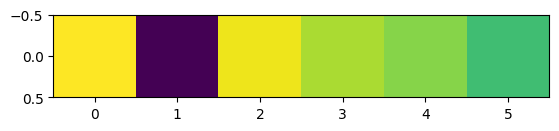

In [37]:
feature_names = ["num_equations", "mean_num_new_symbols_introduced", "num_overall_unique_symbols", "mean_num_unique_symbols", "std_of_unique_symbols", "max_representational_complexity"]
iclr_corrs = [np.corrcoef(iclr[name][iclr_indices], iclr_status)[0, 1] for name in feature_names]
neurips_corrs = [np.corrcoef(neurips[name][neurips_indices], neurips_status)[0, 1] for name in feature_names]

plt.imshow(np.array(iclr_corrs).reshape(1, -1))
plt.show()


# plt.imshow(np.array(neurips_corrs).reshape(1, -1))
# plt.show()

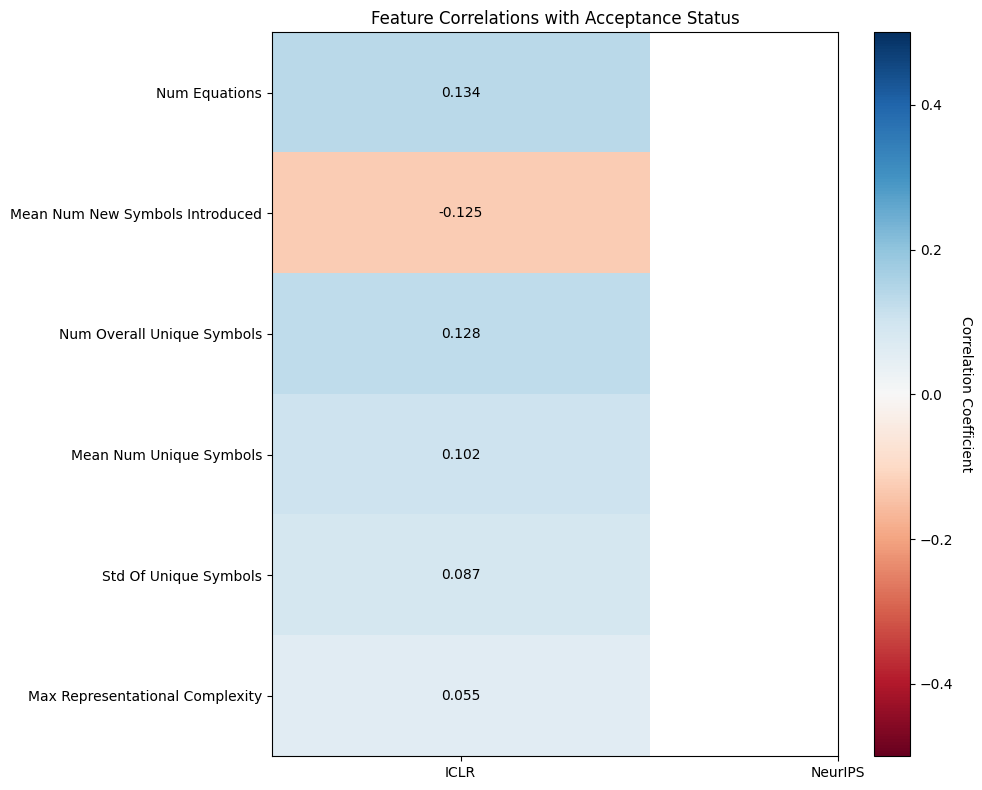

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Format feature names for better readability
feature_names = [
    "num_equations",
    "mean_num_new_symbols_introduced",
    "num_overall_unique_symbols",
    "mean_num_unique_symbols",
    "std_of_unique_symbols",
    "max_representational_complexity"
]
formatted_features = [name.replace('_', ' ').title() for name in feature_names]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
im = ax.imshow(np.array([iclr_corrs]).T, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlation Coefficient', rotation=-90, va="bottom")

# Configure axis labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(len(feature_names)))
ax.set_xticklabels(['ICLR', 'NeurIPS'])
ax.set_yticklabels(formatted_features)

# Rotate y-axis labels for better readability
plt.setp(ax.get_yticklabels(), ha="right", rotation_mode="anchor")

# Add correlation values as text annotations
for i in range(len(feature_names)):
    for j in range(1):
        value = iclr_corrs[i] if j == 0 else neurips_corrs[i]
        text_color = 'white' if abs(value) > 0.5 else 'black'
        ax.text(j, i, f'{value:.3f}', 
                ha="center", va="center", color=text_color)

# Add title
plt.title('Feature Correlations with Acceptance Status')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Are Accept and Reject Populations different? (Hypothesis test)

In [39]:
import numpy as np
from scipy import stats

def compare_means(sample1, sample2, alpha=0.05):
    """
    Perform multiple hypothesis tests to compare means of two samples.
    """
    t_stat, t_pval = stats.ttest_ind(sample1, sample2)
    welch_stat, welch_pval = stats.ttest_ind(sample1, sample2, equal_var=False)
    mw_stat, mw_pval = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')
    
    results = {
        "Sample Statistics": {
            "Sample 1 Mean": np.mean(sample1),
            "Sample 2 Mean": np.mean(sample2),
            "Sample 1 Size": len(sample1),
            "Sample 2 Size": len(sample2)
        },
        "Student's t-test": {
            "statistic": t_stat,
            "p-value": t_pval,
            "significant": t_pval < alpha
        },
        "Welch's t-test": {
            "statistic": welch_stat,
            "p-value": welch_pval,
            "significant": welch_pval < alpha
        },
        "Mann-Whitney U test": {
            "statistic": mw_stat,
            "p-value": mw_pval,
            "significant": mw_pval < alpha
        }
    }
    
    return results


out = {}
for name in feature_names:
    data = iclr[name][iclr_indices]
    sample1 = data[iclr_status == 1]
    sample2 = data[iclr_status == 0]
    results = compare_means(sample1, sample2)

    res = {}
    for test_name in ["Student's t-test", "Welch's t-test", "Mann-Whitney U test"]:
        res[test_name.replace("'", "")] = results[test_name]['p-value']
    out[name] = res

In [41]:
out

{'num_equations': {'Students t-test': np.float64(3.1735994971956415e-05),
  'Welchs t-test': np.float64(1.8814544188000106e-05),
  'Mann-Whitney U test': np.float64(2.9481698189917777e-06)},
 'mean_num_new_symbols_introduced': {'Students t-test': np.float64(0.00010169250000364114),
  'Welchs t-test': np.float64(0.00013818422812220157),
  'Mann-Whitney U test': np.float64(0.00011065088051026158)},
 'num_overall_unique_symbols': {'Students t-test': np.float64(7.537382527441616e-05),
  'Welchs t-test': np.float64(7.134249595163728e-05),
  'Mann-Whitney U test': np.float64(1.5081616414316525e-05)},
 'mean_num_unique_symbols': {'Students t-test': np.float64(0.0016451635164558963),
  'Welchs t-test': np.float64(0.001640806738818492),
  'Mann-Whitney U test': np.float64(0.002228117507997262)},
 'std_of_unique_symbols': {'Students t-test': np.float64(0.007310877638463532),
  'Welchs t-test': np.float64(0.007976009314098918),
  'Mann-Whitney U test': np.float64(0.004020188837406068)},
 'max_rep

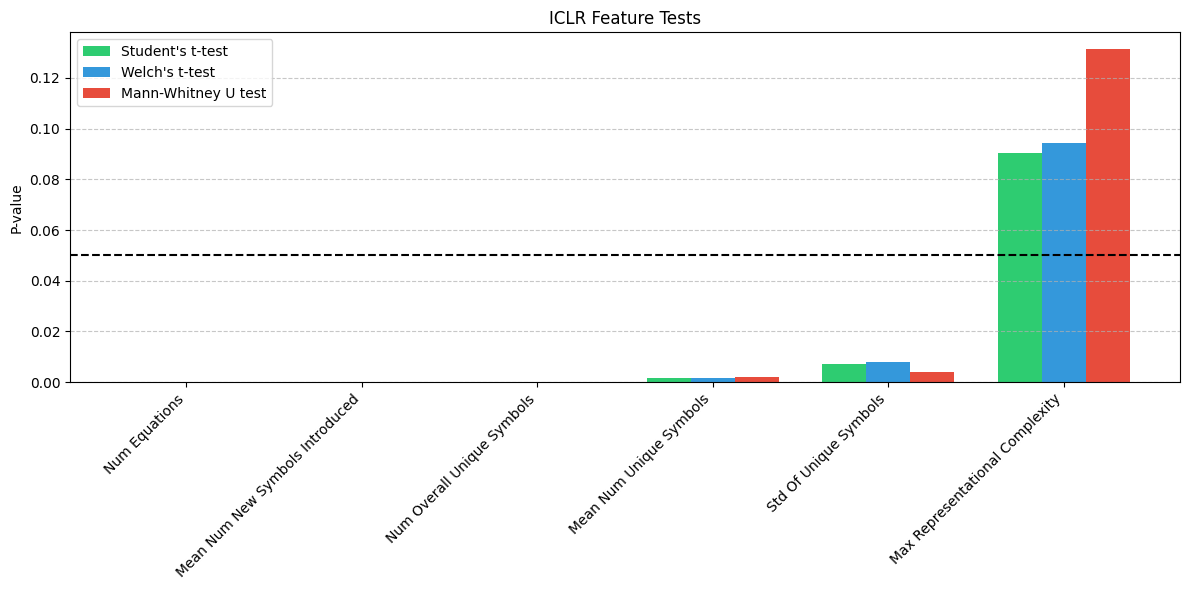

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
tests = ["Students t-test", "Welchs t-test", "Mann-Whitney U test"]
features = list(data.keys())

# Create arrays for each test
students_data = [out[name]["Students t-test"] for name in feature_names]
welch_data = [out[name]["Welchs t-test"] for name in feature_names]
mann_whitney_data = [out[name]["Mann-Whitney U test"] for name in feature_names]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
x = np.arange(len(feature_names))
width = 0.25

bars1 = ax.bar(x - width, students_data, width, label="Student's t-test", color='#2ecc71')
bars2 = ax.bar(x, welch_data, width, label="Welch's t-test", color='#3498db')
bars3 = ax.bar(x + width, mann_whitney_data, width, label="Mann-Whitney U test", color='#e74c3c')

# Customize the plot
ax.set_ylabel('P-value')
ax.set_title('ICLR Feature Tests')
ax.set_xticks(x)
ax.set_xticklabels([feat.replace('_', ' ').title() for feat in feature_names], rotation=45, ha='right')
ax.legend()

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.axhline(0.05, linestyle="--", color="black", label="p-value = 0.05")

# Adjust layout to prevent label cutoff
plt.tight_layout()
# Show plot
plt.show()